Creating graph structure...
Preparing datasets with preprocessed graphs...
Initializing model...
Starting training...
Epoch [1/15], Train Loss: 0.0604, Test Loss: 0.0418


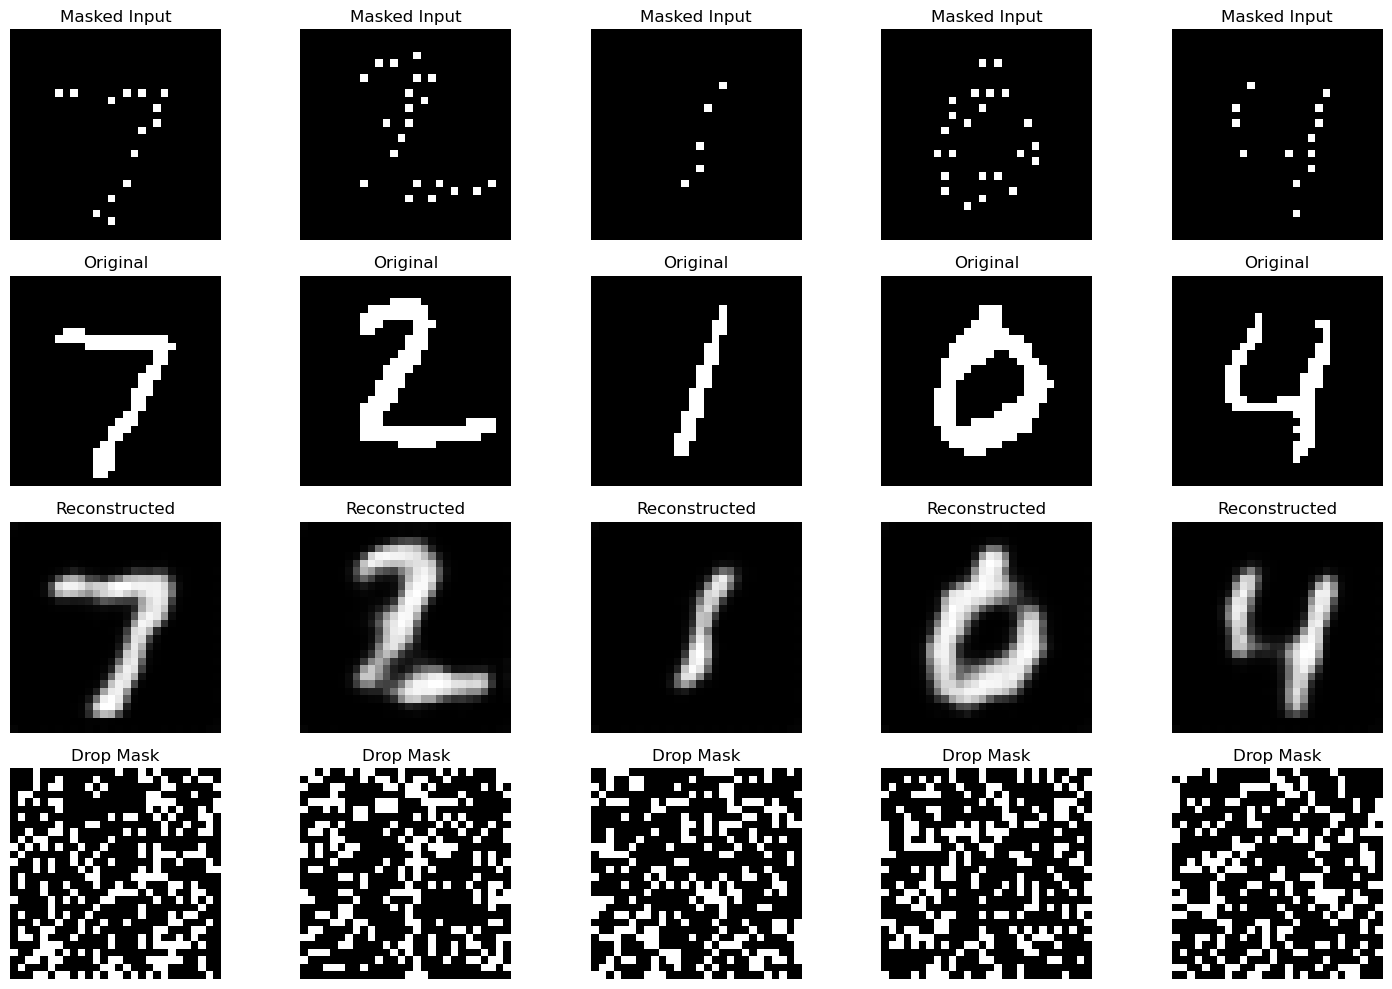

Epoch [2/15], Train Loss: 0.0413, Test Loss: 0.0405
Epoch [3/15], Train Loss: 0.0404, Test Loss: 0.0399
Epoch [4/15], Train Loss: 0.0398, Test Loss: 0.0394
Epoch [5/15], Train Loss: 0.0394, Test Loss: 0.0391


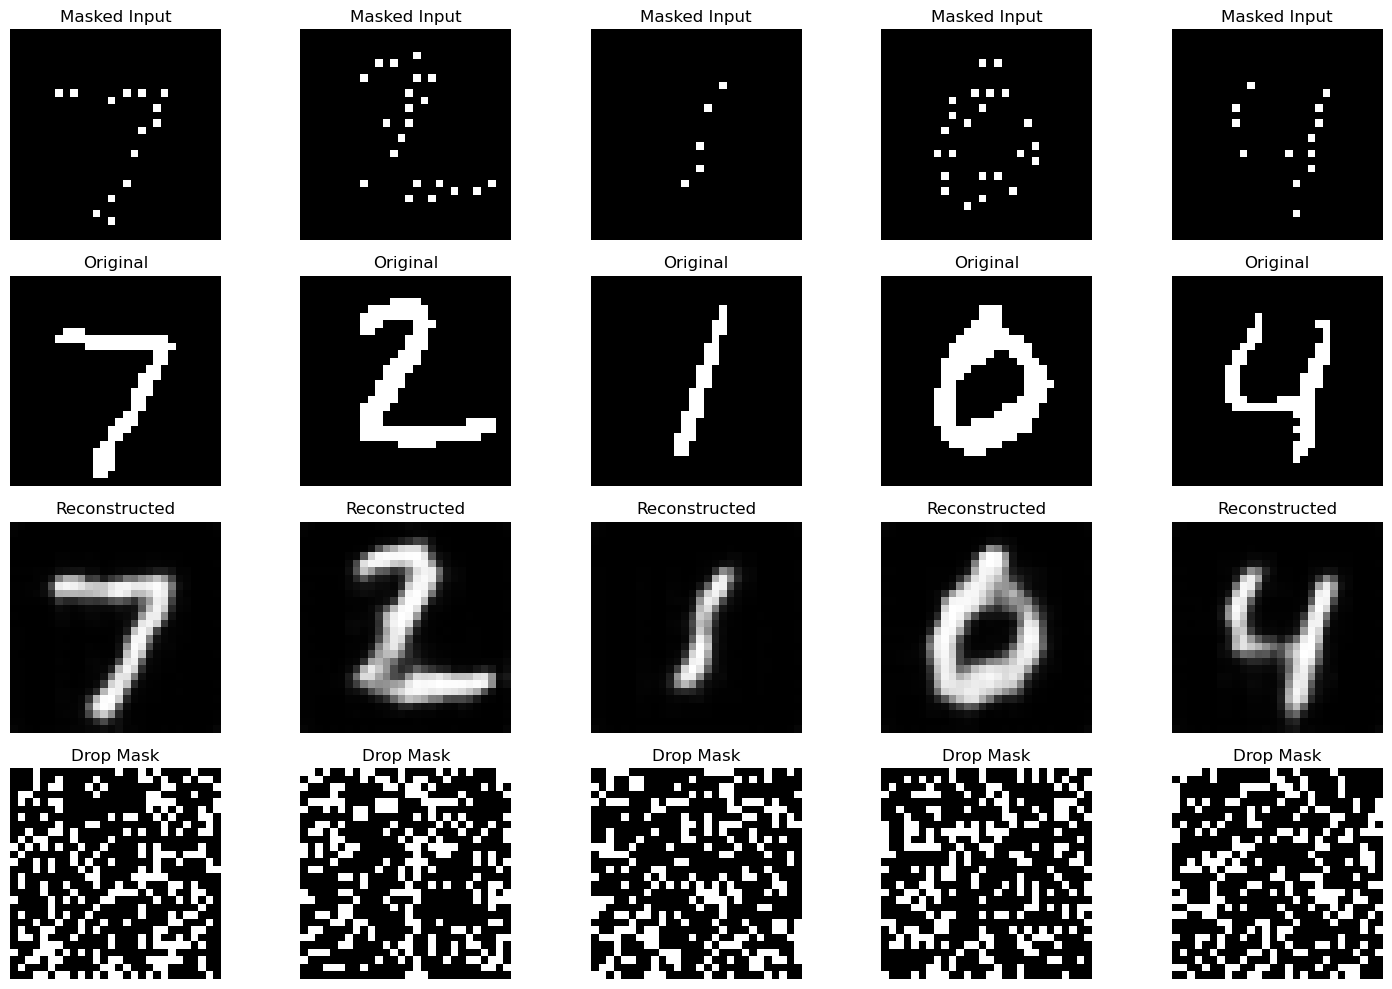

Epoch [6/15], Train Loss: 0.0392, Test Loss: 0.0390
Epoch [7/15], Train Loss: 0.0390, Test Loss: 0.0388
Epoch [8/15], Train Loss: 0.0388, Test Loss: 0.0388
Epoch [9/15], Train Loss: 0.0387, Test Loss: 0.0385
Epoch [10/15], Train Loss: 0.0386, Test Loss: 0.0384


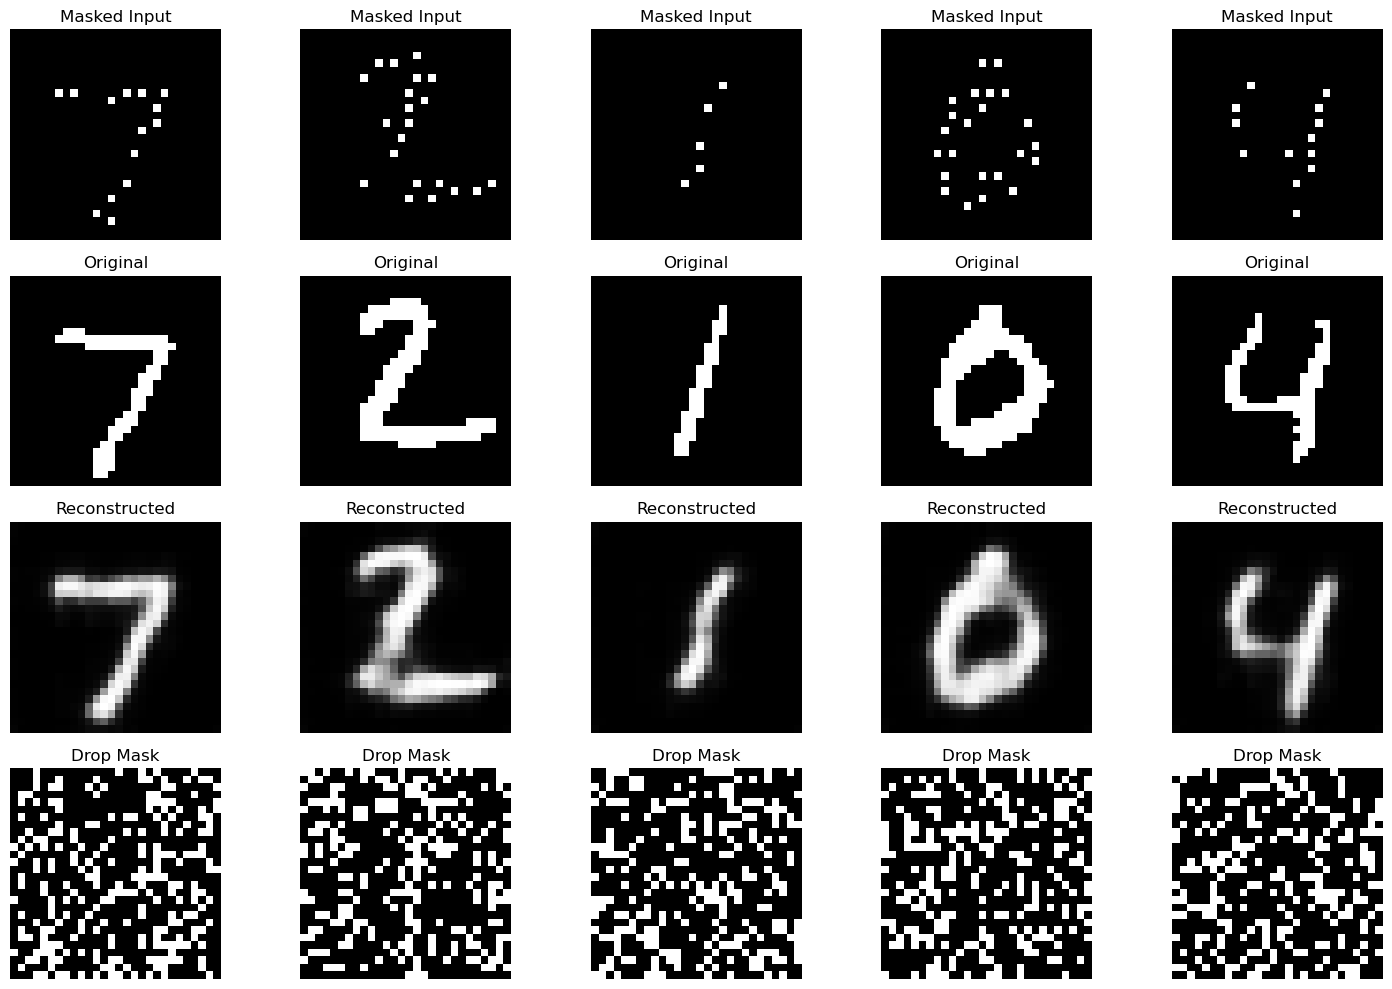

Epoch [11/15], Train Loss: 0.0385, Test Loss: 0.0383
Epoch [12/15], Train Loss: 0.0385, Test Loss: 0.0383
Epoch [13/15], Train Loss: 0.0384, Test Loss: 0.0383
Epoch [14/15], Train Loss: 0.0383, Test Loss: 0.0382
Epoch [15/15], Train Loss: 0.0383, Test Loss: 0.0381


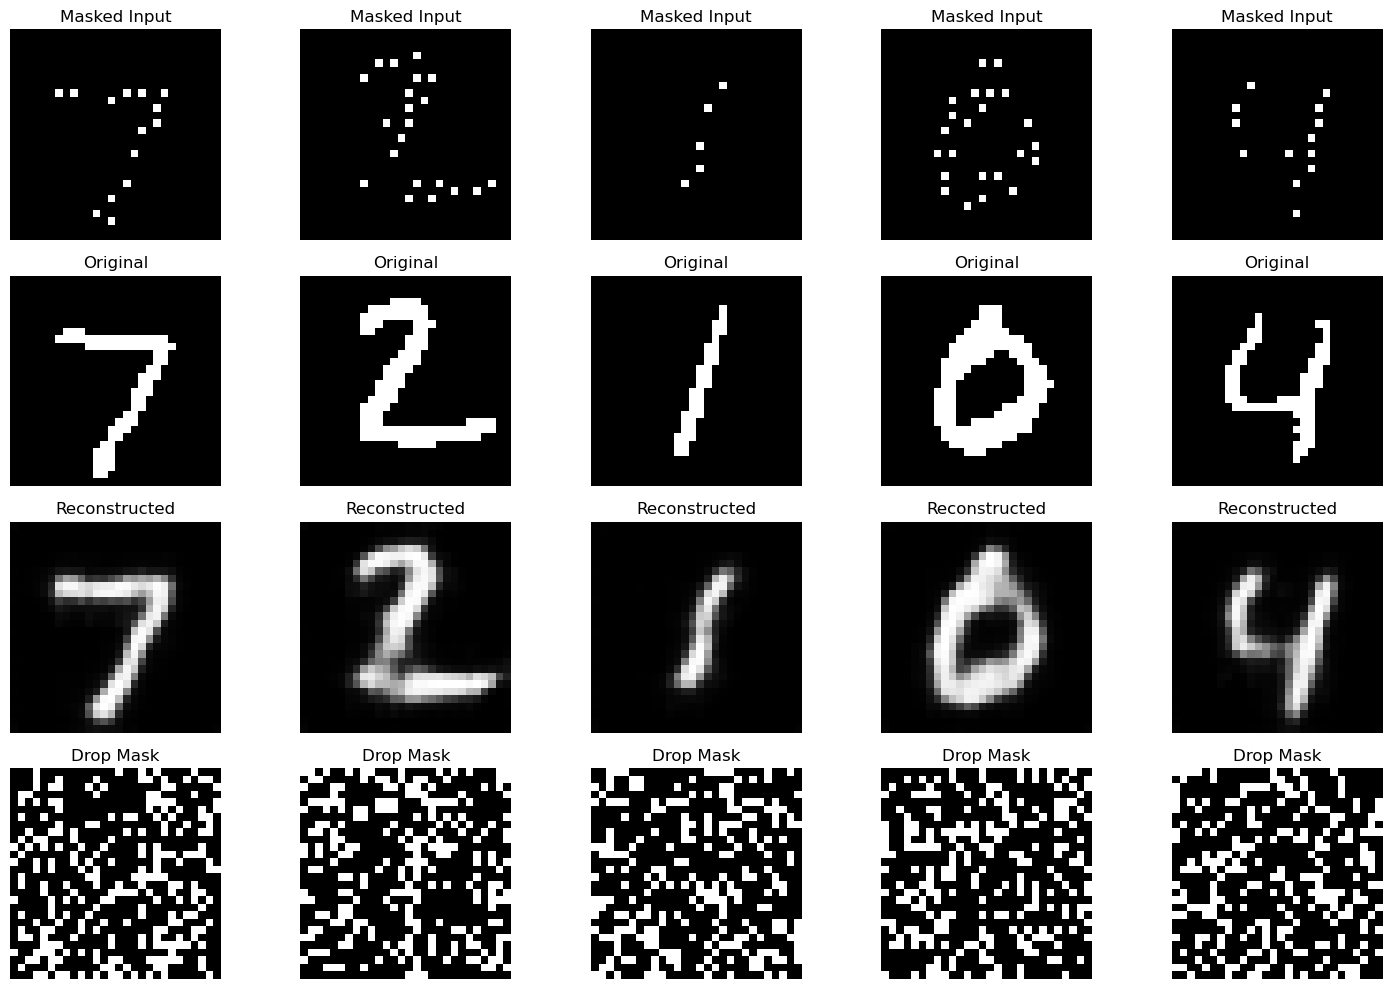

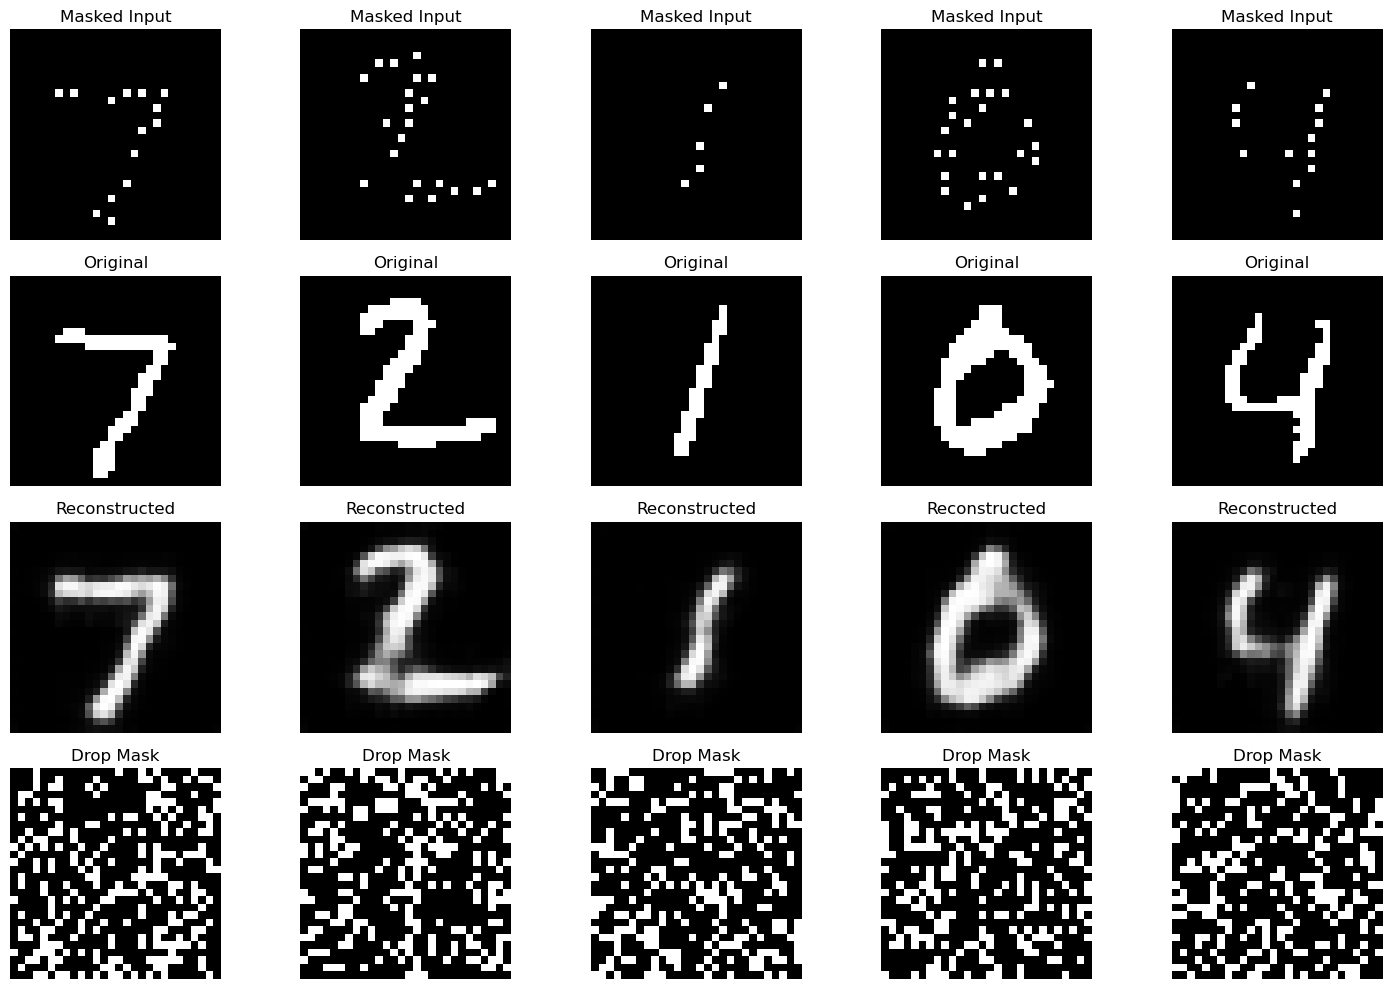

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import random
import os
import pickle

#  Définition des Hyperparamètres
DISCONNECT_PERCENTAGE = 0.7
LEARNING_RATE =1e-3
NUM_EPOCHS = 15
BATCH_SIZE = 64
K_NEIGHBORS = 8

# choix du device (GPU ou CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#chargement et transformation des données MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def create_geometric_graph_structure():
    ''' Crée une structure de graphe géométrique pour relier les pixels d'une image.'''
    h, w = 28, 28
    n_nodes = h * w
    
    positions = []
    for y in range(h):
        for x in range(w):
            positions.append([x, y])
    positions = np.array(positions)
    
    nbrs = NearestNeighbors(n_neighbors=K_NEIGHBORS+1, algorithm='ball_tree').fit(positions)
    _, indices = nbrs.kneighbors(positions)
    
    adj_list = {}
    for node_idx in range(n_nodes):
        adj_list[node_idx] = indices[node_idx, 1:].tolist()
    
    return {
        'positions': positions,
        'adj_list': adj_list,
        'n_nodes': n_nodes
    }

def apply_node_failures(graph_structure):
    ''' Applique des échecs de noeuds aléatoires au graphe.
    Cela simule des pixels déconnectés dans une image.
    '''
    n_nodes = graph_structure['n_nodes']
    failed_nodes = set(random.sample(range(n_nodes), int(n_nodes * DISCONNECT_PERCENTAGE)))
    return failed_nodes

def create_binary_image(image):
    ''' Convertit une image en un tableau binaire.'''
    flat_image = image.view(-1).numpy()
    binary_image = (flat_image > 0.5).astype(int)
    return binary_image

def calc_win(u, active_set, phase, bit_idx, random_bits):
    ''' Calcule le gagnant d'une étape de l'algorithme MIS.
    L'algorithme MIS est basé sur un processus de vote aléatoire.
    '''
    for v in active_set:
        while len(random_bits[u]) <= phase or len(random_bits[v]) <= phase:
            if len(random_bits[u]) <= phase:
                random_bits[u].append([])
            if len(random_bits[v]) <= phase:
                random_bits[v].append([])
                
        while len(random_bits[u][phase]) <= bit_idx:
            random_bits[u][phase].append(random.randint(0, 1))
        while len(random_bits[v][phase]) <= bit_idx:
            random_bits[v][phase].append(random.randint(0, 1))
            
        b_u = random_bits[u][phase][bit_idx]
        b_v = random_bits[v][phase][bit_idx]
        
        if b_u != b_v:
            return u if b_u < b_v else v
            
    return None

def compute_mis(binary_image, graph_structure, failed_nodes):
    ''' Calcule le masque d'indépendance maximale (MIS) pour une image binaire donnée 
    et une structure de graphe donnée.'''
    n_nodes = graph_structure['n_nodes']
    adj_list = graph_structure['adj_list']
    
    eta = [-1] * n_nodes
    
    for node in failed_nodes:
        eta[node] = 0
    
    active_sets = {}
    for u in range(n_nodes):
        if u in failed_nodes or binary_image[u] == 0:
            continue
        
        active_sets[u] = [v for v in adj_list[u] if v not in failed_nodes and binary_image[v] == 1]
    
    random_bits = [[] for _ in range(n_nodes)]
    
    max_rounds = int(2 * np.log2(n_nodes))
    
    for _ in range(max_rounds):
        phase = 0
        bit_idx = 0
        
        winners = {}
        
        for u in list(active_sets.keys()):
            if eta[u] != -1:
                continue
                
            for v in list(active_sets[u]):
                if eta[v] != -1:
                    active_sets[u].remove(v)
                    continue
                    
                if (u, v) in winners or (v, u) in winners:
                    continue
                    
                winner = calc_win(u, [v], phase, bit_idx, random_bits)
                if winner is not None:
                    winners[(u, v)] = winner
        
        for u in list(active_sets.keys()):
            if eta[u] != -1:
                continue
                
            is_winner = True
            for v in active_sets[u]:
                if (u, v) in winners and winners[(u, v)] != u:
                    is_winner = False
                    break
                if (v, u) in winners and winners[(v, u)] != u:
                    is_winner = False
                    break
                    
            if is_winner:
                eta[u] = 1
                
                for v in active_sets[u]:
                    eta[v] = 0
        
        for u in list(active_sets.keys()):
            if eta[u] != -1:
                del active_sets[u]
                continue
                
            active_sets[u] = [v for v in active_sets[u] if eta[v] == -1]
            
            if not active_sets[u]:
                del active_sets[u]
                
        if not active_sets:
            break
            
        bit_idx += 1
    
    mis_mask = np.array([1 if e == 1 else 0 for e in eta])
    
    return mis_mask

class MNISTGraphDataset(Dataset):
    ''' Un ensemble de données personnalisé pour les images MNIST avec des graphes prétraités.
    Chaque élément de l'ensemble de données est un tuple contenant une image masquée, l'image originale,
    l'étiquette de l'image et un masque binaire indiquant les pixels déconnectés.
    '''
    def __init__(self, dataset, graph_structure, is_train=True):
        self.dataset = dataset
        self.graph_structure = graph_structure
        self.is_train = is_train
        self.processed_data = []
        
        cache_file = f"processed_{'train' if is_train else 'test'}_data.pkl"
        
        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as f:
                self.processed_data = pickle.load(f)
        else:
            self._preprocess_data()
            with open(cache_file, 'wb') as f:
                pickle.dump(self.processed_data, f)
    
    def _preprocess_data(self):
        ''' Prétraite les données en calculant les masques MIS pour chaque image.'''
        for i in range(len(self.dataset)):
            image, label = self.dataset[i]
            
            binary_image = create_binary_image(image)
            failed_nodes = apply_node_failures(self.graph_structure)
            
            mis_mask = compute_mis(binary_image, self.graph_structure, failed_nodes)
            
            failure_mask = np.ones(self.graph_structure['n_nodes'])
            for node in failed_nodes:
                failure_mask[node] = 0
                
            masked_image = binary_image * mis_mask * failure_mask
            
            masked_tensor = torch.FloatTensor(masked_image).view(1, 28, 28)
            original_tensor = torch.FloatTensor(binary_image).view(1, 28, 28)
            failure_tensor = torch.FloatTensor(failure_mask).view(1, 28, 28)
            
            self.processed_data.append((masked_tensor, original_tensor, label, failure_tensor))
            
        
    def __len__(self):
        return len(self.processed_data)
        
    def __getitem__(self, idx):
        return self.processed_data[idx]

class CNNAutoencoder(nn.Module):
    ''' Un auto-encodeur convolutionnel simple pour la reconstruction d'images.'''
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x, failure_mask=None):
        x = self.encoder(x)
        x = self.decoder(x)
        
        if failure_mask is not None:
            x = x * failure_mask
            
        return x

def train(model, train_loader, criterion, optimizer):
    ''' Entraîne le modèle sur un ensemble de données d'entraînement.'''
    model.train()
    total_loss = 0
    
    for masked_img, original_img, _, failure_mask in train_loader:
        masked_img = masked_img.to(device)
        original_img = original_img.to(device)
        failure_mask = failure_mask.to(device)
        
        outputs = model(masked_img)
        loss = criterion(outputs, original_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def test(model, test_loader, criterion):
    ''' Teste le modèle sur un ensemble de données de test.'''
    model.eval()
    total_loss = 0
    examples = []
    
    with torch.no_grad():
        for i, (masked_img, original_img, _, failure_mask) in enumerate(test_loader):
            masked_img = masked_img.to(device)
            original_img = original_img.to(device)
            failure_mask = failure_mask.to(device)
            
            outputs = model(masked_img)
            loss = criterion(outputs, original_img)
            
            total_loss += loss.item()
            
            if i == 0:
                n = min(5, masked_img.size(0))
                examples = [
                    masked_img[:n].cpu(), 
                    original_img[:n].cpu(), 
                    outputs[:n].cpu(),
                    failure_mask[:n].cpu()
                ]
    
    return total_loss / len(test_loader), examples




def visualize_results(examples, epoch):
    ''' Visualise les résultats de la reconstruction d'images.'''
    masked_imgs, original_imgs, reconstructed_imgs, failure_masks = examples
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    
    for i in range(5):
        axes[0, i].imshow(masked_imgs[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Masked Input")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(original_imgs[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Original")
        axes[1, i].axis('off')
        
        axes[2, i].imshow(reconstructed_imgs[i].squeeze(), cmap='gray')
        axes[2, i].set_title("Reconstructed")
        axes[2, i].axis('off')
        
        axes[3, i].imshow(failure_masks[i].squeeze(), cmap='gray')
        axes[3, i].set_title("Drop Mask")
        axes[3, i].axis('off')
        
    plt.tight_layout()
    plt.savefig(f"reconstruction_epoch_{epoch}.png")
    plt.show()
    plt.close()

def main():
    print("Creating graph structure...")
    graph_structure = create_geometric_graph_structure()
    
    print("Preparing datasets with preprocessed graphs...")
    train_graph_dataset = MNISTGraphDataset(train_dataset, graph_structure, is_train=True)
    test_graph_dataset = MNISTGraphDataset(test_dataset, graph_structure, is_train=False)
    
    train_graph_loader = DataLoader(train_graph_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_graph_loader = DataLoader(test_graph_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print("Initializing model...")
    model = CNNAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        train_loss = train(model, train_graph_loader, criterion, optimizer)
        test_loss, examples = test(model, test_graph_loader, criterion)
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_results(examples, epoch + 1)
    
    torch.save(model.state_dict(), 'mis-gmodel-mnist.pth')
    
    test_loss, examples = test(model, test_graph_loader, criterion)
    visualize_results(examples, "final")

if __name__ == "__main__":
    main()